### SDS-043-CardioSentinel: Predicting Heart Attack Risk from Lifestyle and Clinical Data

This notebook performs standard feature engineering per the README: split out or combine columns, formulas, binning, encodings, and preprocessing plan.

Feature Engineering & Experimentation  
Source:  https://www.kaggle.com/datasets/iamsouravbanerjee/heart-attack-prediction-dataset  
Greg Gibson Nov. 2025

###Feature Selection Strategy

Feature selection followed a layered, domain-aware approach designed to balance predictive performance, interpretability, and generalization.

###Core Clinical Features

Demographic and clinical risk factors (e.g., age, sex, diabetes, smoking, blood pressure, cholesterol, BMI) were retained regardless of importance ranking. These variables represent established cardiovascular risk determinants and anchor the model to clinically meaningful inputs, improving trust and external validity.  *A basline logistic regression on core features did not predict any at risk patients.*

###Domain-Engineered Features

Physiologically motivated composite features (e.g., mean arterial pressure, pulse pressure, metabolic score, activity ratios) were engineered to summarize known mechanisms and reduce noise from correlated raw inputs. These features were retained if they demonstrated stable contribution across models or appeared in SHAP importance rankings.

###Interaction Terms

Interaction features were generated to capture conditional risk effects (e.g., age-dependent metabolic burden, geography-modulated blood pressure risk).
Interactions were filtered through:

-Correlation screening (to reduce combinatorial explosion),  
-Mutual information (to identify non-linear signal),  
-Domain-aware redundancy pruning, and  
-L1 regularization.

Final interaction selection was guided by SHAP mean absolute importance, retaining only interactions with material contribution (mean_abs_SHAP ≥ 0.06). This ensured that interaction complexity was justified by observed model behavior rather than arbitrary inclusion.

###Geographic Risk Encoding

Country was encoded via a country risk index, computed from training data only, to capture contextual risk without leakage. Geographic influence appeared only through interactions with physiological variables, confirming that the model did not rely on geography as a proxy for the outcome.

In [71]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import shap
from pathlib import Path
from itertools import combinations
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.utils.class_weight import compute_class_weight
from sklearn.feature_selection import mutual_info_classif, VarianceThreshold
from lightgbm import LGBMClassifier, early_stopping, log_evaluation

In [2]:
# Load dataset, try both likely locations
possible_paths = [
    Path('..') / 'data' / 'raw' / 'heart_attack_prediction_dataset.csv',  # when running from notebooks/
    Path('data') / 'raw' / 'heart_attack_prediction_dataset.csv'          # when running from project root
]

data_path = next((p for p in possible_paths if p.exists()), None)

if data_path is None:
    raise FileNotFoundError("Could not find heart_attack_prediction_dataset.csv in expected locations.")

print("Using data file:", data_path)
df = pd.read_csv(data_path)

# Quick look
print('Shape:', df.shape)
display(df.head())

Using data file: ..\data\raw\heart_attack_prediction_dataset.csv
Shape: (8763, 26)


,Patient ID,Age,Sex,Cholesterol,Blood Pressure,Heart Rate,Diabetes,Family History,Smoking,Obesity,...,Sedentary Hours Per Day,Income,BMI,Triglycerides,Physical Activity Days Per Week,Sleep Hours Per Day,Country,Continent,Hemisphere,Heart Attack Risk
0,BMW7812,67,Male,208,158/88,72,0,0,1,0,...,6.615001,261404,31.251233,286,0,6,Argentina,South America,Southern Hemisphere,0
1,CZE1114,21,Male,389,165/93,98,1,1,1,1,...,4.963459,285768,27.194973,235,1,7,Canada,North America,Northern Hemisphere,0
2,BNI9906,21,Female,324,174/99,72,1,0,0,0,...,9.463426,235282,28.176571,587,4,4,France,Europe,Northern Hemisphere,0
3,JLN3497,84,Male,383,163/100,73,1,1,1,0,...,7.648981,125640,36.464704,378,3,4,Canada,North America,Northern Hemisphere,0
4,GFO8847,66,Male,318,91/88,93,1,1,1,1,...,1.514821,160555,21.809144,231,1,5,Thailand,Asia,Northern Hemisphere,0


In [3]:
# Standardize column names for ML processing
df.columns = (
    df.columns
      .str.strip()
      .str.lower()
      .str.replace(" ", "_")
      .str.replace(r"[^0-9a-zA-Z_]", "", regex=True)
)

In [4]:
# Drop Patient ID as it's not predictive
df = df.drop(columns=['patient_id'])

Column types and grouping

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8763 entries, 0 to 8762
Data columns (total 25 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   age                              8763 non-null   int64  
 1   sex                              8763 non-null   object 
 2   cholesterol                      8763 non-null   int64  
 3   blood_pressure                   8763 non-null   object 
 4   heart_rate                       8763 non-null   int64  
 5   diabetes                         8763 non-null   int64  
 6   family_history                   8763 non-null   int64  
 7   smoking                          8763 non-null   int64  
 8   obesity                          8763 non-null   int64  
 9   alcohol_consumption              8763 non-null   int64  
 10  exercise_hours_per_week          8763 non-null   float64
 11  diet                             8763 non-null   object 
 12  previous_heart_probl

In [6]:
# Function to identify column type groups

def infer_column_groups(
    df: pd.DataFrame,
    target_col: str = None,
    max_cat_unique: int = 20,
    force_numeric=None,
    force_ordinal=None,
    force_categorical=None
):
    """
    Infer column groups for ML preprocessing.

    Groups:
      - numeric: continuous or count-like numbers
      - binary: 0/1 or True/False
      - categorical: nominal categories (no order)
      - ordinal: ordered categories (levels, ratings, small scales)
      - ignore: target or unknown types
    
    Parameters
    ----------
    df : DataFrame
    target_col : str, optional
        Name of target column to exclude.
    max_cat_unique : int
        Int columns with <= this many uniques are *candidates* for categorical/ordinal.
    force_numeric / force_ordinal / force_categorical : list of column names
        Explicit overrides for tricky cases.  
    """
    force_numeric = set(force_numeric or [])
    force_ordinal = set(force_ordinal or [])
    force_categorical = set(force_categorical or [])

    numeric_cols = []
    binary_cols = []
    categorical_cols = []
    ordinal_cols = []
    ignore_cols = []

    def looks_like_ordinal(name: str) -> bool:
        name = name.lower()
        ordinal_keywords = ["level", "rating", "score", "rank", "grade", "size", "stress"]
        return any(k in name for k in ordinal_keywords)

    def looks_like_numeric_count(name: str) -> bool:
        name = name.lower()
        numeric_keywords = [
            "hour", "hours",
            "day", "days",
            "week", "per_week", "per week", "per_day", "per day",
            "count", "num", "number",
            "activity", "sleep", "steps"
        ]
        return any(k in name for k in numeric_keywords)

    for col in df.columns:
        if col == target_col:
            ignore_cols.append(col)
            continue

        s = df[col]
        dtype = s.dtype
        uniques = s.dropna().unique()
        n_unique = len(uniques)

        # -------- Overrides first --------
        if col in force_numeric:
            numeric_cols.append(col)
            continue
        if col in force_ordinal:
            ordinal_cols.append(col)
            continue
        if col in force_categorical:
            categorical_cols.append(col)
            continue

        # -------- Objects → categorical --------
        if dtype == "object":
            categorical_cols.append(col)
            continue

        # -------- Bool → binary --------
        if pd.api.types.is_bool_dtype(dtype):
            binary_cols.append(col)
            continue

        # -------- Integers --------
        if pd.api.types.is_integer_dtype(dtype):
            # Binary 0/1
            if n_unique == 2:
                binary_cols.append(col)
                continue

            # Small integer scale (e.g. 1–10) → treat as ordinal
            col_min = s.min()
            col_max = s.max()
            if pd.notna(col_min) and pd.notna(col_max):
                if col_max <= 10 and n_unique > 2:
                    # e.g., stress_level_1_10, ratings, small scales
                    ordinal_cols.append(col)
                    continue

            # Name-based numeric count heuristic
            if looks_like_numeric_count(col):
                numeric_cols.append(col)
                continue

            # Name-based ordinal heuristic
            if looks_like_ordinal(col) and n_unique <= max_cat_unique:
                ordinal_cols.append(col)
                continue

            # Small unique int set → likely categorical
            if n_unique <= max_cat_unique:
                categorical_cols.append(col)
            else:
                numeric_cols.append(col)
            continue

        # -------- Floats → numeric --------
        if pd.api.types.is_float_dtype(dtype):
            numeric_cols.append(col)
            continue

        # -------- Fallback --------
        ignore_cols.append(col)

    return {
        "numeric": numeric_cols,
        "binary": binary_cols,
        "categorical": categorical_cols,
        "ordinal": ordinal_cols,
        "ignore": ignore_cols,
    }


In [7]:
# List column type groupings
groups = infer_column_groups(df, target_col="heart_attack_risk")

for name, cols in groups.items():
    print(f"\n{name.upper()} columns:")
    for c in cols:
        print(f"  - {c}")


NUMERIC columns:
  - age
  - cholesterol
  - heart_rate
  - exercise_hours_per_week
  - sedentary_hours_per_day
  - income
  - bmi
  - triglycerides

BINARY columns:
  - diabetes
  - family_history
  - smoking
  - obesity
  - alcohol_consumption
  - previous_heart_problems
  - medication_use

CATEGORICAL columns:
  - sex
  - blood_pressure
  - diet
  - country
  - continent
  - hemisphere

ORDINAL columns:
  - stress_level
  - physical_activity_days_per_week
  - sleep_hours_per_day

IGNORE columns:
  - heart_attack_risk


In [8]:
# Extract groups
numeric_cols = groups["numeric"]
binary_cols = groups["binary"]
categorical_cols = groups["categorical"]
ordinal_cols = groups["ordinal"]

target = "heart_attack_risk"

In [9]:
# Object types to Category
for col in categorical_cols:
    df[col] = df[col].astype('category')

Simple column recodes

In [10]:
# Split blood pressure into systolic and diastolic
df[['systolic', 'diastolic']] = df['blood_pressure'].str.split('/', expand=True).astype(int)
df = df.drop(columns=['blood_pressure'])

# Add to numeric columns list
numeric_cols.extend(['systolic', 'diastolic'])

In [11]:
# Map Sex from category to binary 0/1
df['sex'] = df['sex'].map({'Male': 1, 'Female': 0}).astype('int')
binary_cols.append('sex')

Split data before any learning

In [12]:
# Separate target and features
y = df[target]
X = df.drop(columns=[target])

In [13]:
# Train-test split
X_train_full, X_test_full, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7, stratify=y)

Baseline model preparation and results

In [14]:
# For baseline only (no high-cardinality country, no engineered features)
X_train_base = X_train_full.drop(columns=["country"]).copy()
X_test_base  = X_test_full.drop(columns=["country"]).copy()

In [15]:
# Scale numeric features
to_scale = numeric_cols + ordinal_cols

scaler = StandardScaler()
X_train_base[to_scale] = scaler.fit_transform(X_train_base[to_scale])
X_test_base[to_scale]  = scaler.transform(X_test_base[to_scale])

In [16]:
# One-hot-encoding for remaining categorical variables
baseline_cat_cols = ["diet", "continent", "hemisphere"]

ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
train_base_ohe = ohe.fit_transform(X_train_base[baseline_cat_cols])
test_base_ohe  = ohe.transform(X_test_base[baseline_cat_cols])

*Note:  the baseline model does not detect any at risk patients, and has 64% accuracy*

In [17]:
# Train baseline model
lr = LogisticRegression(max_iter=1000, random_state=7)
lr.fit(train_base_ohe, y_train)
y_pred_lr = lr.predict(test_base_ohe)

print("Logistic Regression Classification Report:")
print(classification_report(y_test, y_pred_lr, zero_division=0))

Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.64      1.00      0.78      1125
           1       0.00      0.00      0.00       628

    accuracy                           0.64      1753
   macro avg       0.32      0.50      0.39      1753
weighted avg       0.41      0.64      0.50      1753



Start advanced feature engineering - encode country

In [18]:
# Function to create country risk index feature
def create_country_risk_index(
    X_train: pd.DataFrame,
    X_test: pd.DataFrame,
    y_train: pd.Series,
    country_col: str = "country",
    out_col: str = "country_risk_index",
    smoothing: float = 20.0,
    drop_country: bool = True,
):
    """
    Create a country risk index (target mean encoding) from TRAIN ONLY, apply to TEST.
    
    Parameters
    ----------
    X_train, X_test : pd.DataFrame
        Feature frames that include `country_col`.
    y_train : pd.Series
        Training target (binary 0/1).
    country_col : str
        Name of country column.
    out_col : str
        Name of output numeric feature.
    smoothing : float
        Higher values shrink small-country means toward global mean more strongly.
        Set to 0 to disable smoothing.
    drop_country : bool
        If True, drops the raw country column after creating out_col.
        
    Returns
    -------
    X_train_out, X_test_out, mapping_df
        mapping_df contains per-country counts and the smoothed mean used.
    """
    X_train_out = X_train.copy()
    X_test_out = X_test.copy()

    if country_col not in X_train_out.columns:
        raise KeyError(f"'{country_col}' not found in X_train.")
    if country_col not in X_test_out.columns:
        raise KeyError(f"'{country_col}' not found in X_test.")

    # Global mean risk in training
    global_mean = float(y_train.mean())

    # Per-country stats from TRAIN ONLY
    stats = (
        pd.DataFrame({country_col: X_train_out[country_col], "y": y_train})
        .groupby(country_col, observed=True)["y"]
        .agg(["mean", "count"])
        .rename(columns={"mean": "country_mean", "count": "n"})
    )

    if smoothing and smoothing > 0:
        # Smoothed mean: (n*mean + smoothing*global) / (n + smoothing)
        stats["encoded"] = (stats["n"] * stats["country_mean"] + smoothing * global_mean) / (stats["n"] + smoothing)
    else:
        stats["encoded"] = stats["country_mean"]

    # Map onto train/test; unseen countries in test -> global mean
    mapping = stats["encoded"].to_dict()
    train_mapped = X_train_out[country_col].map(mapping)
    test_mapped  = X_test_out[country_col].map(mapping)

    X_train_out[out_col] = pd.to_numeric(train_mapped, errors="coerce").fillna(global_mean)
    X_test_out[out_col]  = pd.to_numeric(test_mapped,  errors="coerce").fillna(global_mean)

    if drop_country:
        X_train_out = X_train_out.drop(columns=[country_col])
        X_test_out = X_test_out.drop(columns=[country_col])

    mapping_df = stats.reset_index().sort_values("n", ascending=False)

    return X_train_out, X_test_out, mapping_df


In [19]:
# Create country risk index feature with no smoothing (equal representation per EDA)
for d in (X_train_full, X_test_full):
    d.drop(columns=["country_risk_index"], errors="ignore", inplace=True)

# Store advanced feature engineered datasets
X_train_adv, X_test_adv, country_map = create_country_risk_index(
    X_train_full, X_test_full, y_train,
    smoothing=0, drop_country=True
)

In [20]:
numeric_cols.append("country_risk_index")

Domain features

In [21]:
# Function to add domain-specific features
def add_domain_features(df, metabolic_scaler=None, fit_metabolic_scaler=False):
    """
    Add domain-specific numeric features to a copy of df.
    
    Parameters
    ----------
    df : pd.DataFrame
        Input dataframe with raw numeric columns:
        ['bmi', 'cholesterol', 'triglycerides', 'systolic', 'diastolic',
         'heart_rate', 'exercise_hours_per_week', 'sedentary_hours_per_day',
         'physical_activity_days_per_week', 'sleep_hours_per_day', 'stress_level',
         'age', ...]
    metabolic_scaler : StandardScaler or None
        If None and fit_metabolic_scaler=True, a new scaler is fit on the 5 metabolic features.
        If not None, it is used to transform (for test set).
    fit_metabolic_scaler : bool
        True when calling on TRAIN data (fit scaler).
        False when calling on TEST data (reuse scaler).
    
    Returns
    -------
    df_out : pd.DataFrame
        Copy of df with new domain features added.
    metabolic_scaler : StandardScaler
        Fitted scaler for the 5 metabolic features (for reuse on test).
    """
    df_out = df.copy()

    # --- Blood pressure derived features ---
    # Avoid division by zero: replace 0 diastolic with 1
    diastolic_safe = df_out["diastolic"].replace(0, 1)
    df_out["bp_ratio"] = df_out["systolic"] / diastolic_safe

    # Pulse pressure (arterial stiffness proxy)
    df_out["pulse_pressure"] = df_out["systolic"] - df_out["diastolic"]

    # Mean arterial pressure (MAP)
    df_out["map"] = (2 * df_out["diastolic"] + df_out["systolic"]) / 3

    # Isolated systolic / diastolic hypertension
    df_out["ish"] = ((df_out["systolic"] >= 130) & (df_out["diastolic"] < 80)).astype(int)
    df_out["idh"] = ((df_out["diastolic"] >= 80) & (df_out["systolic"] < 130)).astype(int)

    # --- Ratios & composite behavioral features ---
    # Heart rate adjusted for age
    df_out["hr_age_ratio"] = df_out["heart_rate"] / df_out["age"].replace(0, 1)

    # Exercise vs sedentary (+1 to avoid div by zero)
    df_out["exer_seden_ratio"] = df_out["exercise_hours_per_week"] / (
        df_out["sedentary_hours_per_day"] + 1
    )

    # Exercise vs active days
    df_out["exer_activ_ratio"] = df_out["exercise_hours_per_week"] / (
        df_out["physical_activity_days_per_week"] + 1
    )

    # Sleep vs stress
    df_out["sleep_stress_ratio"] = df_out["sleep_hours_per_day"] / (df_out["stress_level"] + 1)

    # Lipid vs obesity
    df_out["trig_bmi_ratio"] = df_out["triglycerides"] / df_out["bmi"].replace(0, 1)

    # Risk index: (Cholesterol + MAP) / (Exercise + 1)
    df_out["risk_index"] = (df_out["cholesterol"] + df_out["map"]) / (
        df_out["exercise_hours_per_week"] + 1
    )

    # --- Metabolic Health Score (standardized sum of 5 core features) ---
    metabolic_features = ["bmi", "cholesterol", "triglycerides", "systolic", "diastolic"]

    if metabolic_scaler is None and fit_metabolic_scaler:
        metabolic_scaler = StandardScaler()
        z = metabolic_scaler.fit_transform(df_out[metabolic_features])
    elif metabolic_scaler is not None:
        z = metabolic_scaler.transform(df_out[metabolic_features])
    else:
        # If you call without a scaler and without fitting, just use raw values
        z = df_out[metabolic_features].values

    df_out["metabolic_score"] = z.sum(axis=1)

    return df_out, metabolic_scaler


Add domain features to train and test sets

In [22]:
# Add domain-specific features to advanced datasets
X_train_adv, metabolic_scaler = add_domain_features(
    X_train_adv,
    metabolic_scaler=None,
    fit_metabolic_scaler=True
)


In [23]:
X_test_adv, _ = add_domain_features(
    X_test_adv,
    metabolic_scaler=metabolic_scaler,
    fit_metabolic_scaler=False
)


In [24]:
# List of new domain features
domain_features = [
    "bp_ratio", "pulse_pressure", "map", "ish", "idh",
    "hr_age_ratio", "exer_seden_ratio", "exer_activ_ratio",
    "sleep_stress_ratio", "trig_bmi_ratio", "risk_index",
    "metabolic_score"
]

# Add new features to numeric_cols
numeric_cols.extend([
    'bp_ratio', 'pulse_pressure', 'hr_age_ratio', 'exer_seden_ratio',
    'exer_activ_ratio', 'sleep_stress_ratio', 'trig_bmi_ratio',
    'map', 'risk_index', 'metabolic_score'
])

# Add to binary_cols
binary_cols.extend(['ish', 'idh'])

Risk Index relationship with target

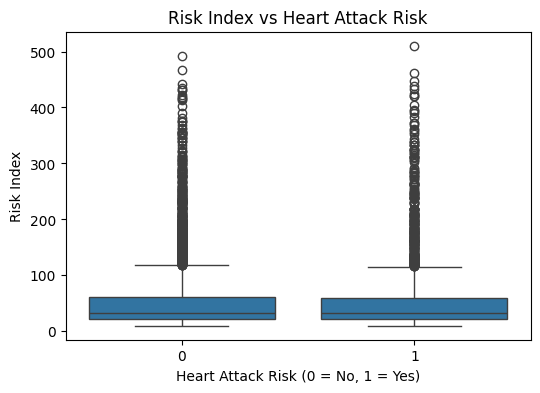

In [25]:
# Create a temporary DataFrame for plotting only
plot_df = X_train_adv.copy()
plot_df[target] = y_train.values  # align by index

plt.figure(figsize=(6,4))
sns.boxplot(data=plot_df, x=target, y="risk_index")
plt.title("Risk Index vs Heart Attack Risk")
plt.xlabel("Heart Attack Risk (0 = No, 1 = Yes)")
plt.ylabel("Risk Index")
plt.show()


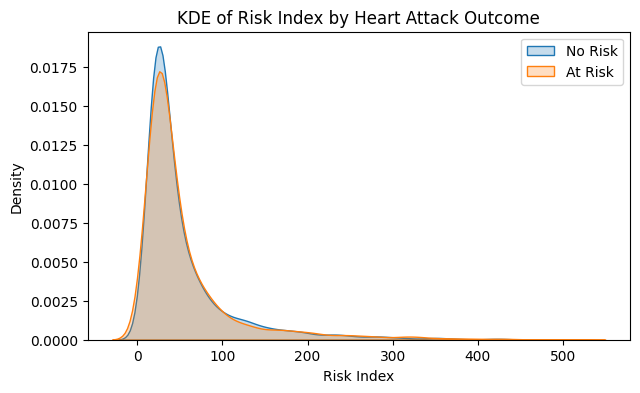

In [26]:
# KDE of Risk Index by Heart Attack Outcome
plt.figure(figsize=(7,4))
sns.kdeplot(
    data=plot_df[plot_df[target] == 0],
    x="risk_index",
    label="No Risk",
    fill=True
)
sns.kdeplot(
    data=plot_df[plot_df[target] == 1],
    x="risk_index",
    label="At Risk",
    fill=True
)

plt.title("KDE of Risk Index by Heart Attack Outcome")
plt.xlabel("Risk Index")
plt.legend()
plt.show()

Create and convert categorical features

In [27]:
# Function to add BP and BMI categories

def add_bp_bmi_categories(df: pd.DataFrame) -> pd.DataFrame:
    """Adds bp_category, bp_high_risk, bmi_category to a copy of df."""
    out = df.copy()

    sys = out["systolic"]
    dia = out["diastolic"]

    # BP category (vectorized)
    out["bp_category"] = np.select(
        [
            (sys >= 180) | (dia >= 120),
            (sys >= 140) | (dia >= 90),
            (sys >= 130) | (dia >= 80),
            (sys >= 120) & (dia < 80),
        ],
        [
            "Hypertensive_Crisis",
            "Hypertension_Stage2",
            "Hypertension_Stage1",
            "Elevated",
        ],
        default="Normal"
    )

    # Binary high risk indicator
    out["bp_high_risk"] = out["bp_category"].str.startswith("Hyper").astype(int)

    # BMI category (vectorized)
    bmi = out["bmi"]
    out["bmi_category"] = np.select(
        [bmi < 18.5, bmi < 25, bmi < 30],
        ["Underweight", "Normal", "Overweight"],
        default="Obese"
    )

    return out


def summarize_category(series: pd.Series) -> pd.DataFrame:
    counts = series.value_counts(dropna=False).rename("count")
    perc = (series.value_counts(normalize=True, dropna=False) * 100).round(2).rename("percent")
    return pd.concat([counts, perc], axis=1)


In [28]:
# Add BP and BMI categories to advanced feature sets

X_train_adv = add_bp_bmi_categories(X_train_adv)
X_test_adv  = add_bp_bmi_categories(X_test_adv)

In [29]:
# Summarize BP categories
bp_counts = X_train_adv["bp_category"].value_counts().rename("count")
bp_perc = (X_train_adv["bp_category"].value_counts(normalize=True) * 100).round(2).rename("percent")

bp_summary = pd.concat([bp_counts, bp_perc], axis=1)
print(bp_summary)

                     count  percent
bp_category                        
Hypertension_Stage2   4734    67.53
Hypertension_Stage1    983    14.02
Normal                 932    13.30
Elevated               285     4.07
Hypertensive_Crisis     76     1.08


In [30]:
# Summarize BMI categories
bmi_counts = X_train_adv["bmi_category"].value_counts().rename("count")
bmi_perc = (X_train_adv["bmi_category"].value_counts(normalize=True) * 100).round(2).rename("percent")

bmi_summary = pd.concat([bmi_counts, bmi_perc], axis=1)
print(bmi_summary)

              count  percent
bmi_category                
Obese          3101    44.24
Normal         2091    29.83
Overweight     1655    23.61
Underweight     163     2.33


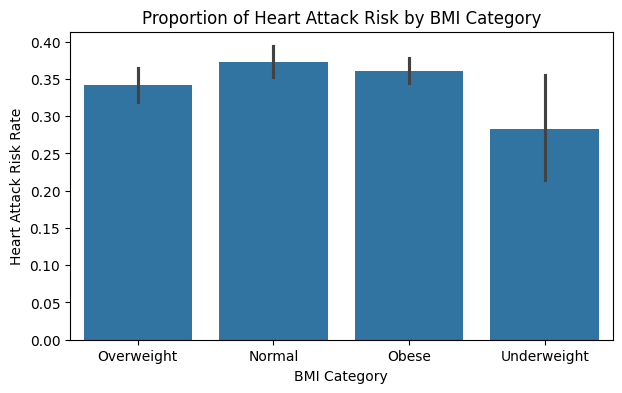

In [31]:
# Bar plot of Heart Attack Risk by BMI Category

plot_df = X_train_adv.copy()
plot_df[target] = y_train.values  # align by index

plt.figure(figsize=(7,4))
sns.barplot(
    data=plot_df,
    x="bmi_category",
    y=target,
    estimator=lambda x: sum(x) / len(x)  # percentage with risk=1
)
plt.title("Proportion of Heart Attack Risk by BMI Category")
plt.ylabel("Heart Attack Risk Rate")
plt.xlabel("BMI Category")
plt.show()

Create interaction terms, then prune

In [32]:
# Include select one hot encoded categorical features (without drop first) for interaction terms
inter_df = plot_df.copy()
inter_df = inter_df.drop(columns=['continent', 'hemisphere'])
inter_df = pd.get_dummies(inter_df, columns=['diet', 'bmi_category', 'bp_category'], dtype=int)

In [33]:
# Extend binary_cols with new one hot encoded columns
binary_cols.extend([col for col in inter_df.columns if col.startswith('diet_') or col.startswith('bmi_category_') or col.startswith('bp_category_')])

In [34]:
# Combine numeric and ordinal columns for interaction terms
nums_combo = numeric_cols + ordinal_cols

In [35]:
# Function to screen interaction candidates
def screen_interactions(
    df: pd.DataFrame,
    target_col: str,
    numeric_cols=None,
    binary_cols=None,
    min_abs_corr: float = 0.0,
    top_n: int = 30
) -> pd.DataFrame:
    """
    Screen 'meaningful' interaction candidates and rank them by absolute
    correlation with the target.

    - Considers:
        * numeric × numeric
        * binary × numeric
    - Skips:
        * binary × binary
        * categorical features (not handled here)

    Parameters
    ----------
    df : DataFrame
        Full dataset including target.
    target_col : str
        Name of the binary target column (0/1).
    numeric_cols : list[str], optional
        List of numeric feature names. If None, inferred.
    binary_cols : list[str], optional
        List of binary feature names. If None, inferred.
    min_abs_corr : float, default 0.0
        Filter out interactions with |corr| below this threshold.
    top_n : int, default 30
        Return only the top N interactions by |corr|.

    Returns
    -------
    result_df : DataFrame with columns:
        ['feature_a', 'feature_b', 'interaction_name',
         'pair_type', 'corr', 'abs_corr']
    """
    df = df.copy()

    # --- Infer groups if not provided ---
#    if numeric_cols is None or binary_cols is None:
#        numeric_cols_inferred, binary_cols_inferred = infer_basic_groups(df, target_col)
#        if numeric_cols is None:
#            numeric_cols = numeric_cols_inferred
#        if binary_cols is None:
#            binary_cols = binary_cols_inferred

    target = df[target_col]
    records = []

    # --- 1) Numeric × Numeric pairs ---
    for f1, f2 in combinations(numeric_cols, 2):
        inter_name = f"{f1}__x__{f2}"
        inter_values = df[f1] * df[f2]

        # Drop rows with NaN in either feature or target
        valid = pd.concat([inter_values, target], axis=1).dropna()
        if valid[target_col].nunique() < 2:
            continue  # degenerate case

        corr = valid.iloc[:, 0].corr(valid.iloc[:, 1])

        if pd.isna(corr):
            continue

        abs_corr = abs(corr)
        if abs_corr >= min_abs_corr:
            records.append({
                "feature_a": f1,
                "feature_b": f2,
                "interaction_name": inter_name,
                "pair_type": "num*num",
                "corr": corr,
                "abs_corr": abs_corr
            })

    # --- 2) Binary × Numeric pairs ---
    for b in binary_cols:
        for n in numeric_cols:
            inter_name = f"{b}__x__{n}"
            inter_values = df[b] * df[n]

            valid = pd.concat([inter_values, target], axis=1).dropna()
            if valid[target_col].nunique() < 2:
                continue

            corr = valid.iloc[:, 0].corr(valid.iloc[:, 1])
            if pd.isna(corr):
                continue

            abs_corr = abs(corr)
            if abs_corr >= min_abs_corr:
                records.append({
                    "feature_a": b,
                    "feature_b": n,
                    "interaction_name": inter_name,
                    "pair_type": "bin*num",
                    "corr": corr,
                    "abs_corr": abs_corr
                })

    # --- Build result DataFrame ---
    result_df = pd.DataFrame(records)
    if result_df.empty:
        return result_df

    result_df = result_df.sort_values("abs_corr", ascending=False)
    if top_n is not None:
        result_df = result_df.head(top_n).reset_index(drop=True)

    return result_df


Sort interaction terms by correlation to target

In [36]:
# Screen interactions, keeping only those with |corr| >= 0.01, top 40
interaction_df = screen_interactions(
    df=inter_df,
    target_col=target,
    numeric_cols=nums_combo,
    binary_cols=binary_cols,
    min_abs_corr=0.01,
    top_n=40
)

display(interaction_df)

,feature_a,feature_b,interaction_name,pair_type,corr,abs_corr
0,systolic,country_risk_index,systolic__x__country_risk_index,num*num,0.034651,0.034651
1,idh,metabolic_score,idh__x__metabolic_score,bin*num,0.033081,0.033081
2,age,pulse_pressure,age__x__pulse_pressure,num*num,0.032546,0.032546
3,bmi_category_Obese,metabolic_score,bmi_category_Obese__x__metabolic_score,bin*num,0.032114,0.032114
4,bp_category_Hypertensive_Crisis,physical_activity_days_per_week,bp_category_Hypertensive_Crisis__x__physical_a...,bin*num,0.031753,0.031753
5,diastolic,sleep_hours_per_day,diastolic__x__sleep_hours_per_day,num*num,-0.031709,0.031709
6,bmi_category_Underweight,age,bmi_category_Underweight__x__age,bin*num,-0.031582,0.031582
7,country_risk_index,bp_ratio,country_risk_index__x__bp_ratio,num*num,0.030360,0.030360
8,diet_Healthy,metabolic_score,diet_Healthy__x__metabolic_score,bin*num,0.030222,0.030222
9,cholesterol,pulse_pressure,cholesterol__x__pulse_pressure,num*num,0.029762,0.029762


In [37]:
# Add interaction columns to dataset
def add_interaction_columns_from_df(df, interaction_df):
    """
    df: main DataFrame with base feature columns
    interaction_df: has ['feature_a', 'feature_b', 'interaction_name']
    """
    df = df.copy()
    created_cols = []

    for _, row in interaction_df.iterrows():
        f1 = row["feature_a"]
        f2 = row["feature_b"]
        new_col = row["interaction_name"]

        if f1 not in df.columns or f2 not in df.columns:
            print(f"Skipping {new_col}: missing {f1} or {f2} in df.")
            continue

        df[new_col] = df[f1] * df[f2]
        created_cols.append(new_col)

    return df, created_cols

In [38]:
inter_df, interaction_features = add_interaction_columns_from_df(inter_df, interaction_df)

Filter interaction terms with low variance

In [39]:
# Extract just the interaction columns from inter_df
interaction_cols = interaction_df["interaction_name"].tolist()

# Apply VarianceThreshold
vt = VarianceThreshold(threshold=1e-6)
mask = vt.fit(inter_df[interaction_cols]).get_support()

# Filter out near-constant interactions
kept_interactions = [col for col, keep in zip(interaction_cols, mask) if keep]

# Update interaction_df to keep only survivors
interaction_df = interaction_df[interaction_df["interaction_name"].isin(kept_interactions)].copy()

In [40]:
print("interactions: ",len(interaction_cols))
print("kept: ",len(kept_interactions))

interactions:  40
kept:  40


Filter top interaction terms using mutual information (signal vs noise)

In [41]:
# Compute correlation and mutual information for interaction features

def compute_corr_mi_with_pairtype(df, interaction_df, target):
    rows = []
    y = df[target]

    for _, row in interaction_df.iterrows():
        f1 = row["feature_a"]
        f2 = row["feature_b"]
        inter = row["interaction_name"]
        pair_type = row["pair_type"]

        # safety: skip if interaction column somehow missing
        if inter not in df.columns:
            print(f"Skipping {inter}: interaction column not found in df.")
            continue

        x1 = df[f1]
        x2 = df[f2]
        x_inter = df[inter]

        # --- correlation ---
        def safe_corr(a, b):
            return 0.0 if a.nunique(dropna=True) < 2 else a.corr(b)

        corr1 = safe_corr(x1, y)
        corr2 = safe_corr(x2, y)
        corr_inter = safe_corr(x_inter, y)

        # --- mutual information ---
        def mi_single(col):
            return mutual_info_classif(df[[col]].values, y, discrete_features='auto', random_state=7)[0]

        mi1 = mi_single(f1)
        mi2 = mi_single(f2)
        mi_inter = mi_single(inter)

        rows.append({
            "feature_a": f1,
            "feature_b": f2,
            "interaction_name": inter,
            "pair_type": pair_type,
            "corr1": corr1,
            "corr2": corr2,
            "corr_inter": corr_inter,
            "abs_corr_inter": abs(corr_inter),
            "mi1": mi1,
            "mi2": mi2,
            "mi_parent_max": max(mi1, mi2),
            "mi_inter": mi_inter
        })

    return pd.DataFrame(rows)

In [42]:
interaction_stats = compute_corr_mi_with_pairtype(inter_df, interaction_df, target)
interaction_stats.head(20)

,feature_a,feature_b,interaction_name,pair_type,corr1,corr2,corr_inter,abs_corr_inter,mi1,mi2,mi_parent_max,mi_inter
0,systolic,country_risk_index,systolic__x__country_risk_index,num*num,0.022484,0.044840,0.034651,0.034651,0.004210,0.003678,0.004210,0.003044
1,idh,metabolic_score,idh__x__metabolic_score,bin*num,-0.013238,0.021604,0.033081,0.033081,0.000000,0.001663,0.001663,0.000000
2,age,pulse_pressure,age__x__pulse_pressure,num*num,0.013162,0.024170,0.032546,0.032546,0.003700,0.005029,0.005029,0.010096
3,bmi_category_Obese,metabolic_score,bmi_category_Obese__x__metabolic_score,bin*num,0.004920,0.021604,0.032114,0.032114,0.000000,0.001663,0.001663,0.000000
4,bp_category_Hypertensive_Crisis,physical_activity_days_per_week,bp_category_Hypertensive_Crisis__x__physical_a...,bin*num,0.019469,0.001940,0.031753,0.031753,0.000000,0.000000,0.000000,0.000000
5,diastolic,sleep_hours_per_day,diastolic__x__sleep_hours_per_day,num*num,-0.009028,-0.028220,-0.031709,0.031709,0.002930,0.000000,0.002930,0.005987
6,bmi_category_Underweight,age,bmi_category_Underweight__x__age,bin*num,-0.024455,0.013162,-0.031582,0.031582,0.000000,0.003700,0.003700,0.000000
7,country_risk_index,bp_ratio,country_risk_index__x__bp_ratio,num*num,0.044840,0.021714,0.030360,0.030360,0.003678,0.000000,0.003678,0.000000
8,diet_Healthy,metabolic_score,diet_Healthy__x__metabolic_score,bin*num,0.011534,0.021604,0.030222,0.030222,0.000000,0.001663,0.001663,0.000000
9,cholesterol,pulse_pressure,cholesterol__x__pulse_pressure,num*num,0.019644,0.024170,0.029762,0.029762,0.006582,0.005029,0.006582,0.002243


In [43]:
# Decide which interactions to keep based on pair type and gain criteria

def decide_keep_with_pairtype(interaction_stats, binary_gain_factor=1.05, min_mi_inter=0.0):
    df = interaction_stats.copy()

    # num*num: just require MI above threshold
    df["keep_numnum"] = (df["pair_type"] == "num*num") & (df["mi_inter"] >= min_mi_inter)

    # bin*num: require interaction to beat best parent MI by gain factor
    df["keep_binnum"] = (
        (df["pair_type"] == "bin*num") &
        (df["mi_inter"] >= binary_gain_factor * df["mi_parent_max"]) &
        (df["mi_inter"] >= min_mi_inter)
    )

    df["keep"] = df["keep_numnum"] | df["keep_binnum"]
    return df

interaction_decisions = decide_keep_with_pairtype(interaction_stats,
                                                  binary_gain_factor=1.05,
                                                  min_mi_inter=0.0)

interaction_decisions[["interaction_name", "pair_type", "mi1", "mi2", "mi_inter", "keep"]]


,interaction_name,pair_type,mi1,mi2,mi_inter,keep
0,systolic__x__country_risk_index,num*num,0.004210,0.003678,0.003044,True
1,idh__x__metabolic_score,bin*num,0.000000,0.001663,0.000000,False
2,age__x__pulse_pressure,num*num,0.003700,0.005029,0.010096,True
3,bmi_category_Obese__x__metabolic_score,bin*num,0.000000,0.001663,0.000000,False
4,bp_category_Hypertensive_Crisis__x__physical_a...,bin*num,0.000000,0.000000,0.000000,True
5,diastolic__x__sleep_hours_per_day,num*num,0.002930,0.000000,0.005987,True
6,bmi_category_Underweight__x__age,bin*num,0.000000,0.003700,0.000000,False
7,country_risk_index__x__bp_ratio,num*num,0.003678,0.000000,0.000000,True
8,diet_Healthy__x__metabolic_score,bin*num,0.000000,0.001663,0.000000,False
9,cholesterol__x__pulse_pressure,num*num,0.006582,0.005029,0.002243,True


In [44]:
# Show top 10 interactions by mutual information with target - check
interaction_stats.sort_values("mi_inter", ascending=False).head(10)


,feature_a,feature_b,interaction_name,pair_type,corr1,corr2,corr_inter,abs_corr_inter,mi1,mi2,mi_parent_max,mi_inter
2,age,pulse_pressure,age__x__pulse_pressure,num*num,0.013162,0.024170,0.032546,0.032546,0.003700,0.005029,0.005029,0.010096
36,bmi,metabolic_score,bmi__x__metabolic_score,num*num,0.007308,0.021604,0.025234,0.025234,0.000000,0.001663,0.001663,0.009016
17,cholesterol,country_risk_index,cholesterol__x__country_risk_index,num*num,0.019644,0.044840,0.027347,0.027347,0.006582,0.003678,0.006582,0.007629
26,pulse_pressure,risk_index,pulse_pressure__x__risk_index,num*num,0.024170,0.008492,0.026368,0.026368,0.005029,0.001310,0.005029,0.007302
5,diastolic,sleep_hours_per_day,diastolic__x__sleep_hours_per_day,num*num,-0.009028,-0.028220,-0.031709,0.031709,0.002930,0.000000,0.002930,0.005987
0,systolic,country_risk_index,systolic__x__country_risk_index,num*num,0.022484,0.044840,0.034651,0.034651,0.004210,0.003678,0.004210,0.003044
9,cholesterol,pulse_pressure,cholesterol__x__pulse_pressure,num*num,0.019644,0.024170,0.029762,0.029762,0.006582,0.005029,0.006582,0.002243
13,income,pulse_pressure,income__x__pulse_pressure,num*num,0.009695,0.024170,0.028657,0.028657,0.000000,0.005029,0.005029,0.001981
23,bmi_category_Normal,age,bmi_category_Normal__x__age,bin*num,0.020159,0.013162,0.026475,0.026475,0.000000,0.003700,0.003700,0.000479
7,country_risk_index,bp_ratio,country_risk_index__x__bp_ratio,num*num,0.044840,0.021714,0.030360,0.030360,0.003678,0.000000,0.003678,0.000000


In [45]:
interactions_to_keep = interaction_decisions.loc[
    interaction_decisions["keep"], "interaction_name"
].tolist()

In [46]:
print("Interactions to keep:", len(interactions_to_keep))
for inter in interactions_to_keep:
    print(f"  - {inter}")

Interactions to keep: 26
  - systolic__x__country_risk_index
  - age__x__pulse_pressure
  - bp_category_Hypertensive_Crisis__x__physical_activity_days_per_week
  - diastolic__x__sleep_hours_per_day
  - country_risk_index__x__bp_ratio
  - cholesterol__x__pulse_pressure
  - bp_category_Elevated__x__sedentary_hours_per_day
  - cholesterol__x__bp_ratio
  - income__x__pulse_pressure
  - cholesterol__x__systolic
  - country_risk_index__x__pulse_pressure
  - cholesterol__x__country_risk_index
  - country_risk_index__x__map
  - age__x__bp_ratio
  - smoking__x__sleep_hours_per_day
  - bmi_category_Underweight__x__triglycerides
  - pulse_pressure__x__risk_index
  - bmi_category_Underweight__x__stress_level
  - age__x__metabolic_score
  - metabolic_score__x__stress_level
  - metabolic_score__x__physical_activity_days_per_week
  - bmi_category_Overweight__x__physical_activity_days_per_week
  - bmi__x__metabolic_score
  - age__x__systolic
  - cholesterol__x__bmi
  - bmi_category_Underweight__x__bmi

Filter out overlapping binary * number interaction terms using feature families

In [47]:
# Lists to sets
binary_set = set(binary_cols)
numeric_set = set(nums_combo)

In [48]:
# Define mapping of numeric features to families, for interaction selection

numeric_family_map = {
    # Lipid family
    "cholesterol": "lipid",
    "triglycerides": "lipid",
    "trig_bmi_ratio": "lipid",

    # Blood pressure family
    "systolic": "bp",
    "diastolic": "bp",
    "bp_ratio": "bp",
    "pulse_pressure": "bp",
    "map": "bp",

    # Anthropometric / metabolic family
    "bmi": "body",
    "age": "body",
    "metabolic_score": "metabolic",
    "risk_index": "metabolic",
    "hr_age_ratio": "cardio",
    "heart_rate": "cardio",

    # Activity / lifestyle family
    "exercise_hours_per_week": "activity",
    "sedentary_hours_per_day": "activity",
    "exer_seden_ratio": "activity",
    "exer_activ_ratio": "activity",
    "physical_activity_days_per_week": "activity",
    "sleep_hours_per_day": "recovery",
    "sleep_stress_ratio": "recovery",

    # Stress
    "stress_level": "stress",

    # Income stays separate
    "income": "income",

    # Geographic risk stays separate
    "geo_risk": "create_country_risk_index"
}

In [49]:
# Parent annotation using pair_type + sets
def annotate_bin_numeric_parents_with_lists(interaction_decisions, binary_set, numeric_set):
    """
    interaction_decisions: DataFrame with columns
      ['feature_a', 'feature_b', 'interaction_name', 'pair_type', 'mi_inter', ...]
    Adds:
      - binary_parent
      - numeric_parent
    using existing binary/numeric lists.
    """
    df = interaction_decisions.copy()

    bin_parents = []
    num_parents = []

    for _, row in df.iterrows():
        a = row["feature_a"]
        b = row["feature_b"]
        pair_type = row["pair_type"]

        bin_parent = None
        num_parent = None

        if pair_type == "bin*num":
            if (a in binary_set) and (b in numeric_set):
                bin_parent, num_parent = a, b
            elif (b in binary_set) and (a in numeric_set):
                bin_parent, num_parent = b, a
            else:
                # Unexpected mismatch: leave as None so we don't try to group it
                bin_parent, num_parent = None, None

        bin_parents.append(bin_parent)
        num_parents.append(num_parent)

    df["binary_parent"] = bin_parents
    df["numeric_parent"] = num_parents
    return df

interaction_dec_annot = annotate_bin_numeric_parents_with_lists(
    interaction_decisions,
    binary_set=binary_set,
    numeric_set=numeric_set
)

In [50]:
# Function to get numeric feature family
def get_numeric_root(name: str) -> str:
    name = name.lower()
    if name in numeric_family_map:
        return numeric_family_map[name]
    # fallback: use first token
    return name.split("_")[0]

def add_numeric_root(interaction_dec_annot):
    df = interaction_dec_annot.copy()
    numeric_roots = []
    for _, row in df.iterrows():
        if row["pair_type"] == "bin*num" and row["numeric_parent"] is not None:
            numeric_roots.append(get_numeric_root(row["numeric_parent"]))
        else:
            numeric_roots.append(None)
    df["numeric_root"] = numeric_roots
    return df

def mark_redundant_bin_numeric(interaction_dec_annot):
    df = interaction_dec_annot.copy()
    df["redundant_bin_numeric"] = False

    mask = (
        (df["pair_type"] == "bin*num") &
        df["binary_parent"].notna() &
        df["numeric_root"].notna()
    )
    df_bin = df[mask]

    groups = df_bin.groupby(["binary_parent", "numeric_root"])
    for _, group in groups:
        if len(group) <= 1:
            continue
        group_sorted = group.sort_values("mi_inter", ascending=False)
        to_drop_idx = group_sorted.index[1:]
        df.loc[to_drop_idx, "redundant_bin_numeric"] = True

    return df

# Apply:
interaction_dec_annot = add_numeric_root(interaction_dec_annot)
interaction_dec_final = mark_redundant_bin_numeric(interaction_dec_annot)

# Combine with existing "keep" flag:
final_interactions_mask = interaction_dec_final["keep"] & (~interaction_dec_final["redundant_bin_numeric"])
final_interactions = interaction_dec_final.loc[final_interactions_mask, "interaction_name"].tolist()

In [51]:
print("Final interactions to keep:", len(final_interactions))
for inter in final_interactions:
    print(f"  - {inter}")

Final interactions to keep: 25
  - systolic__x__country_risk_index
  - age__x__pulse_pressure
  - bp_category_Hypertensive_Crisis__x__physical_activity_days_per_week
  - diastolic__x__sleep_hours_per_day
  - country_risk_index__x__bp_ratio
  - cholesterol__x__pulse_pressure
  - bp_category_Elevated__x__sedentary_hours_per_day
  - cholesterol__x__bp_ratio
  - income__x__pulse_pressure
  - cholesterol__x__systolic
  - country_risk_index__x__pulse_pressure
  - cholesterol__x__country_risk_index
  - country_risk_index__x__map
  - age__x__bp_ratio
  - smoking__x__sleep_hours_per_day
  - bmi_category_Underweight__x__triglycerides
  - pulse_pressure__x__risk_index
  - bmi_category_Underweight__x__stress_level
  - age__x__metabolic_score
  - metabolic_score__x__stress_level
  - metabolic_score__x__physical_activity_days_per_week
  - bmi_category_Overweight__x__physical_activity_days_per_week
  - bmi__x__metabolic_score
  - age__x__systolic
  - cholesterol__x__bmi


In [52]:
# Restrict interaction data to the final interaction names
interaction_df_final = interaction_df[
    interaction_df["interaction_name"].isin(final_interactions)
].copy()

L1 (Lasso) Regularization for feature selection

In [62]:
# Reset dataframe for L1 modeling
L1_df = plot_df.copy()
L1_df = pd.get_dummies(L1_df, columns=['diet', 'continent', 'hemisphere', 'bmi_category', 'bp_category'], dtype=int)

In [63]:
# Add final interaction columns
L1_df, created_cols = add_interaction_columns_from_df(L1_df, interaction_df_final)

In [64]:
# Verify created columns match final interactions
set(created_cols) == set(final_interactions)

True

In [65]:
# Verify all final interactions are in L1_df
set(final_interactions) <= set(L1_df.columns)

True

In [66]:
# Prepare data for L1-regularized logistic regression
features_for_l1 = L1_df.columns.tolist()
y = L1_df[target]
features_for_l1.remove(target)

X = L1_df[features_for_l1].copy()
X = X.fillna(X.median())
scaler = StandardScaler()
Xs = scaler.fit_transform(X)

clf_l1 = LogisticRegression(
    penalty="l1",
    solver="liblinear",
    max_iter=500
)

clf_l1.fit(Xs, y)

coef_df = pd.DataFrame({
    "feature": features_for_l1,
    "coef": clf_l1.coef_[0]
})
coef_df["abs_coef"] = coef_df["coef"].abs()
coef_df = coef_df.sort_values("abs_coef", ascending=False)

# Keep non-zero L1 coefficients
l1_kept = coef_df.query("abs_coef > 0")["feature"].tolist()
print("Total features before L1:", len(features_for_l1))
print("Features kept by L1 regularization:", len(l1_kept))
l1_kept

Total features before L1: 80
Features kept by L1 regularization: 60


['country_risk_index__x__map',
 'sleep_hours_per_day',
 'diastolic__x__sleep_hours_per_day',
 'cholesterol__x__bmi',
 'map',
 'smoking__x__sleep_hours_per_day',
 'country_risk_index__x__pulse_pressure',
 'metabolic_score',
 'cholesterol__x__country_risk_index',
 'age__x__pulse_pressure',
 'cholesterol__x__systolic',
 'country_risk_index__x__bp_ratio',
 'bp_category_Hypertensive_Crisis__x__physical_activity_days_per_week',
 'bp_category_Elevated__x__sedentary_hours_per_day',
 'income__x__pulse_pressure',
 'bmi_category_Obese',
 'pulse_pressure__x__risk_index',
 'smoking',
 'bmi_category_Overweight__x__physical_activity_days_per_week',
 'bmi',
 'age__x__metabolic_score',
 'metabolic_score__x__stress_level',
 'bmi_category_Underweight__x__triglycerides',
 'age',
 'bp_category_Hypertensive_Crisis',
 'bmi_category_Normal',
 'physical_activity_days_per_week',
 'hr_age_ratio',
 'metabolic_score__x__physical_activity_days_per_week',
 'income',
 'sleep_stress_ratio',
 'bmi_category_Underweight_

SHAP feature reduction

In [72]:
X_train = L1_df[l1_kept].copy()
y_train = L1_df[target].copy()

lgbm = LGBMClassifier(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=-1,
    subsample=0.8,
    colsample_bytree=0.8,
    num_leaves=31,
    random_state=7,
    class_weight='balanced' # optimizing minority class recall
)


lgbm.fit(X_train, y_train)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 2511, number of negative: 4499
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003109 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7005
[LightGBM] [Info] Number of data points in the train set: 7010, number of used features: 60
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


,boosting_type,'gbdt'
,num_leaves,31
,max_depth,-1
,learning_rate,0.05
,n_estimators,500
,subsample_for_bin,200000
,objective,None
,class_weight,'balanced'
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


In [ ]:
# Compute SHAP values

# Sample for speed / stability
X_shap = X_train.sample(n=min(2000, len(X_train)), random_state=7)

explainer = shap.TreeExplainer(lgbm)
shap_values = explainer.shap_values(X_shap)

# For binary classification
sv = shap_values[1] if isinstance(shap_values, list) else shap_values

c:\Users\ggibs\SuperDataScience\GitHub\SDS-CP043-cardiosentinel\advanced\submissions\team-members\greg-gibson\venv\Lib\site-packages\shap\explainers\_tree.py:586: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


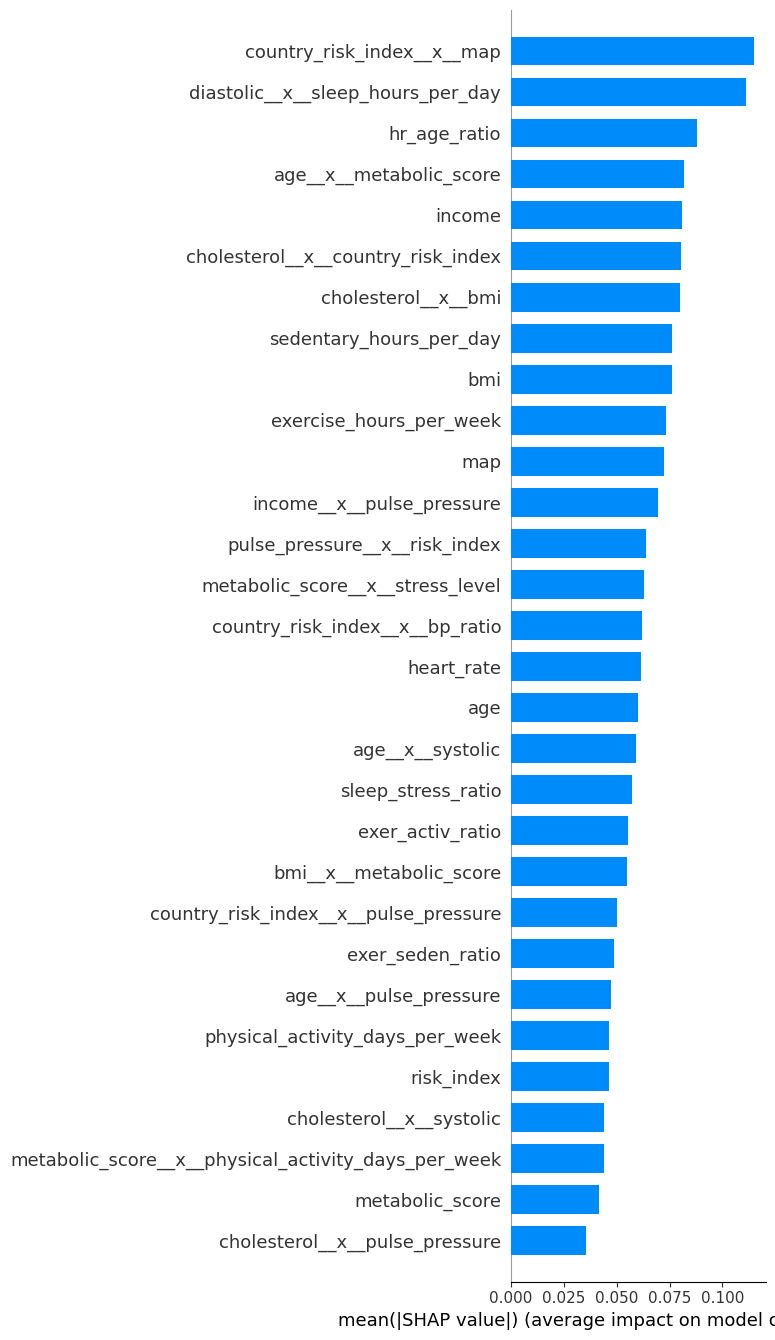

In [77]:
# Global SHAP importance (bar plot)
shap.summary_plot(sv, X_shap, plot_type="bar", max_display=30)

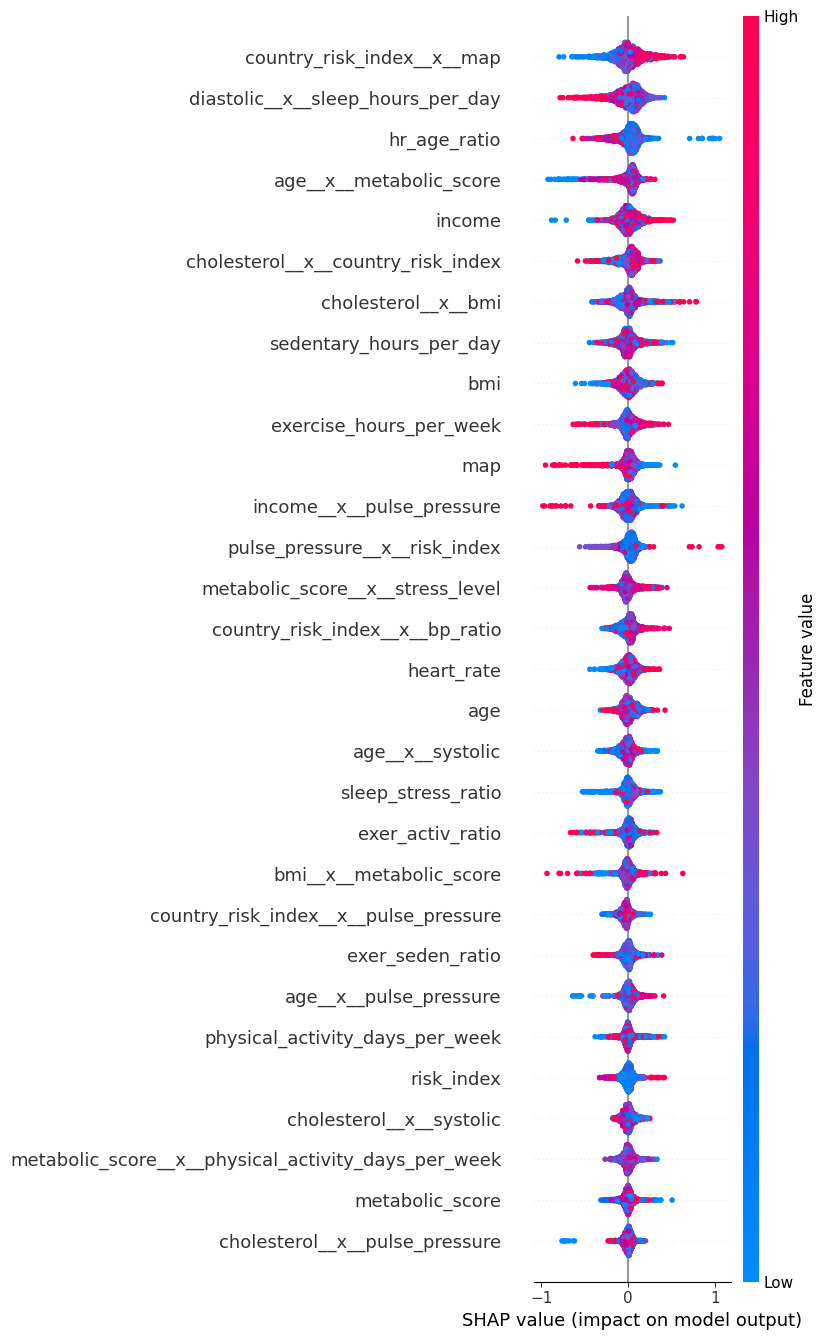

In [79]:
# Global impact and direction (beeswarm)
shap.summary_plot(sv, X_shap, max_display=30)

In [89]:
# Make a sortable SHAP importance table
mean_abs_shap = np.abs(sv).mean(axis=0)

shap_importance = pd.DataFrame({
    "feature": X_shap.columns,
    "mean_abs_shap": mean_abs_shap
}).sort_values("mean_abs_shap", ascending=False)

shap_importance.head(20)

,feature,mean_abs_shap
0,country_risk_index__x__map,0.114777
2,diastolic__x__sleep_hours_per_day,0.111081
27,hr_age_ratio,0.087789
20,age__x__metabolic_score,0.081796
29,income,0.080910
8,cholesterol__x__country_risk_index,0.080349
3,cholesterol__x__bmi,0.079809
45,sedentary_hours_per_day,0.076374
19,bmi,0.076114
43,exercise_hours_per_week,0.073146


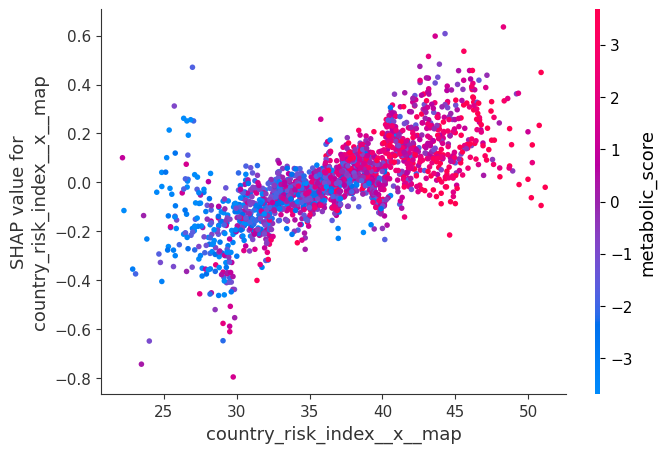

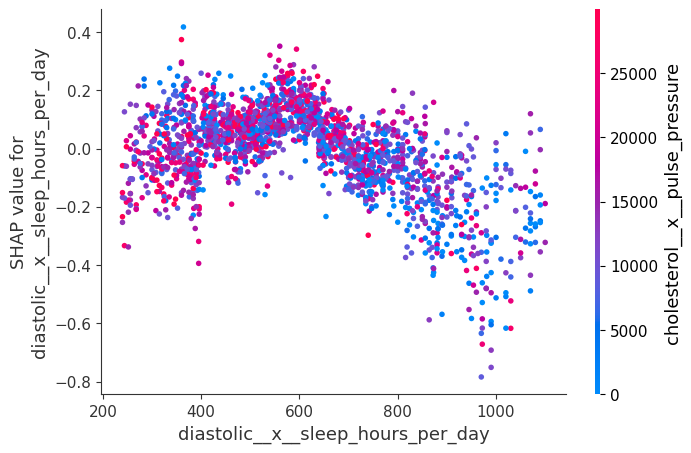

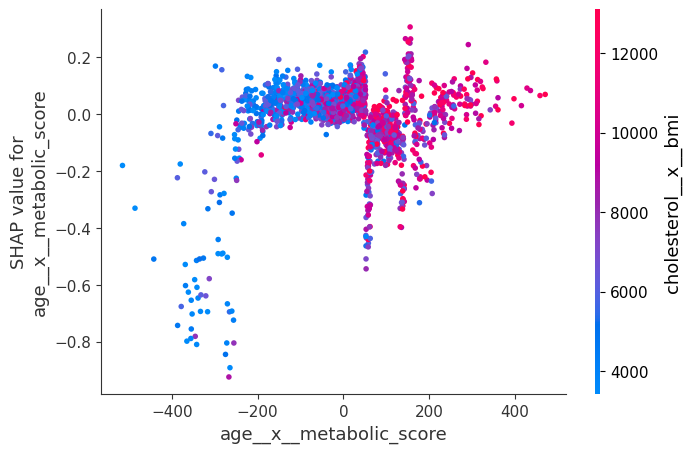

In [84]:
# SHAP dependence plots for top interaction feature
shap.dependence_plot(
    "country_risk_index__x__map",
    sv, X_shap
)

shap.dependence_plot(
    "diastolic__x__sleep_hours_per_day",
    sv, X_shap
)

shap.dependence_plot(
    "age__x__metabolic_score",
    sv, X_shap
)

Final interaction columns

In [90]:
SHAP_THRESHOLD = 0.06

final_interactions = (
    shap_importance
        .query("mean_abs_shap >= @SHAP_THRESHOLD")
        .loc[lambda df: df["feature"].str.contains("__x__")]
        .sort_values("mean_abs_shap", ascending=False)
)

final_interactions


,feature,mean_abs_shap
0,country_risk_index__x__map,0.114777
2,diastolic__x__sleep_hours_per_day,0.111081
20,age__x__metabolic_score,0.081796
8,cholesterol__x__country_risk_index,0.080349
3,cholesterol__x__bmi,0.079809
14,income__x__pulse_pressure,0.069344
16,pulse_pressure__x__risk_index,0.063765
21,metabolic_score__x__stress_level,0.063018
11,country_risk_index__x__bp_ratio,0.061913


In [91]:
final_interaction_names = final_interactions["feature"].tolist()
final_interaction_names


['country_risk_index__x__map',
 'diastolic__x__sleep_hours_per_day',
 'age__x__metabolic_score',
 'cholesterol__x__country_risk_index',
 'cholesterol__x__bmi',
 'income__x__pulse_pressure',
 'pulse_pressure__x__risk_index',
 'metabolic_score__x__stress_level',
 'country_risk_index__x__bp_ratio']